### Imports

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import random
import abc
import tensorflow as tf

### Interfaces

In [1]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer"""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Implements learning loop for the model.
        
        kwargs can contain optional parameters such as 
        num_epochs, batch_size, etc.
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts outputs based on inputs (x)."""
        pass



### Dataset

In [4]:
cifar = tf.keras.datasets.cifar10

ORDERED_CLASS_NAMES=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(x_train, y_train), (x_test, y_test) = cifar.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train=np.reshape(x_train,(50000,3072))

x_test=np.reshape(x_test,(10000,3072))

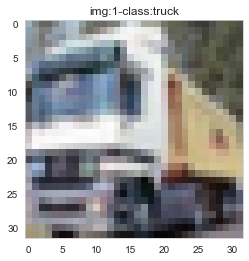

In [5]:
def plot_image(collection,number,labels=None,predicted=None):
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax=plt.imshow(np.reshape(collection[number],(32, 32, 3)))
    title='img:'+str(number)
    if labels is not None:
        title+='-class:'+ORDERED_CLASS_NAMES[labels[number][0]]
    if predicted is not None:
        title+='-pred:'+ORDERED_CLASS_NAMES[predicted[number]]
    plt.title(title)
    plt.show()

plot_image(x_train,1,labels=y_train)

### Markdown

In [5]:
class ConnectedLayer(AbstractLayer):

  def __init__(self, input_size,output_size,activation_function):
    super(ConnectedLayer,self).__init__()
    self.w = self.add_weight(shape=(input_size,output_size,),
                             initializer='random_uniform',
                             trainable=True)
    self.b = self.add_weight(shape=(1,output_size),
                             initializer='random_uniform',
                             trainable=True)
    self.activation_function=activation_function

  def call(self, inputs):
    return self.activation_function(tf.matmul(inputs, self.w) + self.b)

In [6]:
class MLPModel(AbstractModel):
    """Constructor accepts list of tuples 
       [<input_size,output_size,activation_fuction>,...] 
       describing each layer
    """
    def __init__(self,layer_params):
        super(MLPModel, self).__init__()
        self.mlp_layers=[]
        for (input_size,output_size,activation_fuction) in layer_params:
            self.mlp_layers.append(ConnectedLayer(input_size,output_size,activation_fuction))
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]

    def call(self, inputs, training=False):
        res=self.layers[0](inputs)
        for layer in self.mlp_layers[1:]:
            res=layer(res)
        return res
    
    @tf.function
    def train_step(self,images, labels,optimizer,loss_function, train_loss_metric,train_accuracy):
        with tf.GradientTape() as tape:
            predictions = self(images)
            loss = loss_function(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        train_loss_metric(loss)
        train_accuracy(labels, predictions)
        
    @tf.function
    def test_step(self,images, labels,loss_function,test_loss_metric,test_accuracy):
        predictions = self(images)
        t_loss = loss_function(labels, predictions)
        test_loss_metric(t_loss)
        test_accuracy(labels, predictions)

    def fit(self,train_xs,train_ys,test_xs,test_ys,loss_function=tf.keras.losses.SparseCategoricalCrossentropy,
            epochs=10,learning_rate=0.01,batch_size=100):
        
        train_ds = tf.data.Dataset.from_tensor_slices((train_xs,train_ys)).shuffle(5000).batch(batch_size)
        
        test_ds = tf.data.Dataset.from_tensor_slices((test_xs, test_ys)).batch(batch_size)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        loss_function=loss_function()
        
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]

        train_loss_metric = tf.keras.metrics.Mean(name='train_loss_metric')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        test_loss_metric = tf.keras.metrics.Mean(name='test_loss_metric')
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        
        for epoch in tqdm(range(epochs)):
            for batch_images,batch_labels in train_ds:
                self.train_step(batch_images, batch_labels,optimizer,loss_function,train_loss_metric,train_accuracy)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels,loss_function,test_loss_metric,test_accuracy)

            template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
            print(template.format(epoch+1,
                        train_loss_metric.result(),
                        train_accuracy.result()*100,
                        test_loss_metric.result(),
                        test_accuracy.result()*100))
            self.train_learning_accuracy.append(train_accuracy.result().numpy()*100)
            self.test_learning_accuracy.append(test_accuracy.result().numpy()*100)
            self.train_learning_losses.append(train_loss_metric.result().numpy())
            self.test_learning_losses.append(test_loss_metric.result().numpy())

            # Reset the metrics for the next epoch
            train_loss_metric.reset_states()
            train_accuracy.reset_states()
            test_loss_metric.reset_states()
            test_accuracy.reset_states()
    
    def predict(self, x):
        res=self.mlp_layers[0](x)
        for layer in self.layers[1:]:
            res=layer(res)
        return np.argmax(res,axis=-1)

In [7]:
def visualize_learning(model):
    sns.set()
    fig, (error_subplot, accuracy_subplot) = plt.subplots(1, 2,figsize=(15,5))
    epochs=[i+1 for i in range(len(model.train_learning_accuracy))]
    
    train_errors,test_errors=model.train_learning_losses,model.test_learning_losses
    train_accuracy,test_accuracy=model.train_learning_accuracy,model.test_learning_accuracy

    accuracy_subplot.plot(epochs,train_accuracy,linestyle='--', marker='o', color='green', label='Traing set accuracy')
    accuracy_subplot.plot(epochs,test_accuracy,linestyle='--', marker='o', color='blue', label='Test set accuracy')
    accuracy_subplot.set_title("Model accuracy change per epoch")
    accuracy_subplot.set_xlabel('Epochs')
    accuracy_subplot.set_ylabel('Loss')
    accuracy_subplot.legend(loc="upper left")
    
    error_subplot.plot(epochs,train_errors,linestyle='--', marker='o', color='red',label='Traing set loss')
    error_subplot.plot(epochs,test_errors,linestyle='--', marker='o', color='orange',label='Test set loss')
    error_subplot.set_title("Model loss change per epoch")
    error_subplot.set_xlabel('Epochs')
    error_subplot.set_ylabel('Loss')
    error_subplot.legend(loc="upper right")

### Training

In [36]:
model=MLPModel([(3072,128,tf.keras.layers.Activation(tf.nn.relu)),
                (128,10,tf.keras.layers.Activation(tf.nn.softmax))])

In [37]:
model.fit(x_train,y_train,x_test,y_test,learning_rate=0.001)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 1.8837467432022095, Accuracy: 32.57200241088867, Test Loss: 1.7539207935333252, Test Accuracy: 37.86000061035156
Epoch 2, Loss: 1.7015963792800903, Accuracy: 39.49800109863281, Test Loss: 1.645269751548767, Test Accuracy: 41.78000259399414
Epoch 3, Loss: 1.6292880773544312, Accuracy: 42.32600021362305, Test Loss: 1.5860810279846191, Test Accuracy: 43.95000076293945
Epoch 4, Loss: 1.5886659622192383, Accuracy: 43.7660026550293, Test Loss: 1.6054970026016235, Test Accuracy: 42.8099975585937

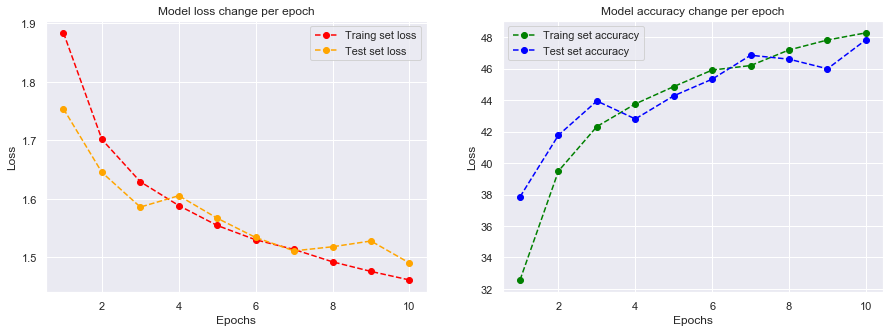

In [38]:
visualize_learning(model)

In [40]:
predicted_labels=model.predict(x_test)

[[648  50  57  20  11   5  23  41  93  52]
 [ 55 667  18  15   9  14  19  18  44 141]
 [111  47 372  86  73  35 146  95  18  17]
 [ 68  37 115 365  21 141 119  62  22  50]
 [ 91  20 196  71 284  30 149 128  20  11]
 [ 49  29 122 261  48 266  86 100  21  18]
 [ 19  24  98 102  76  40 570  42  11  18]
 [ 59  40  76  71  62  51  23 564  11  43]
 [196  90  16  45   9  13   8  18 535  70]
 [ 68 227  15  33   7  12  31  56  38 513]]


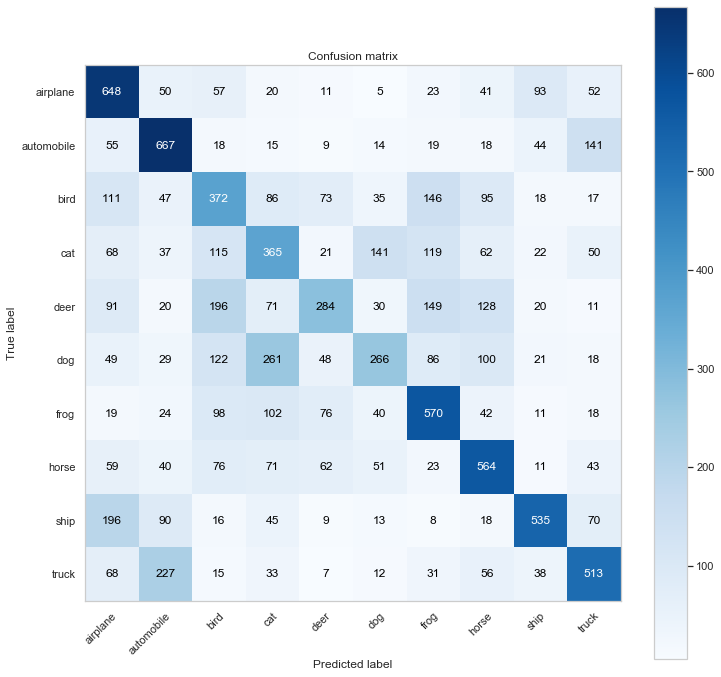

In [41]:
def visualize_confusion_matrix(y_true, y_pred, classes,
                          title=None):

    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    #setting labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # label rotation
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #bug workarond
    ax.set_ylim(len(classes)-0.5, -0.5)
    return ax

visualize_confusion_matrix(y_test, predicted_labels, classes=ORDERED_CLASS_NAMES,
                      title='Confusion matrix')

####  Confusion matrix analysis 

Planes were most often confused with ships,
cars - with ships and trucks,
birds - with frogs, deer and dogs,
cats - with dogs and frogs,
deer - with frogs, snapper and horses,
dogs - with cats and frogs,
frogs - with deer,
horses - with deer and dogs,
ships - with planes,
trucks - with stacks, planes and cars.

Outcome:

Technical facilities were confused with technical facilities.
Biological objects with biological objects, usually of similar overall appearance -> e.g. horses with deer and dogs, because they all have limbs (similarly cats were often mistaken for dogs).
The environment in which the objects were located, e.g.
water is similar to air,
cars and trucks could be depicted on the road,
deer, frogs, birds and dogs could be depicted in a natural setting.


### Visualisations 

In [42]:
def get_wrong_indices_list_per_class(class_id,labels,predicted):
    indexes=[]
    list_predicted=predicted.tolist()
    list_real=labels.transpose()[0].tolist()
    for i in range(len(list_real)):
        if list_real[i]!=list_predicted[i] and list_real[i]==class_id:
            indexes.append(i)
    return indexes

In [43]:
def get_class_indices(class_id,labels):
    result = np.where(labels == class_id)
    return result[0]

In [44]:
def visualize_n_images_horizontally(n, collection, indices_list, labels=None, predicted=None):
    sns.set_style("whitegrid", {'axes.grid' : False})
    fig, subplots = plt.subplots(1, n, figsize=(16,5))
    for subplot in subplots:
        number=random.choice(indices_list)
        ax=subplot.imshow(np.reshape(collection[number],(32, 32, 3)))
        title=str(number)
        if labels is not None:
            title+='-cl:'+ORDERED_CLASS_NAMES[labels[number][0]]
        if predicted is not None:
            title+='-p:'+ORDERED_CLASS_NAMES[predicted[number]]
        subplot.set_title(title)
    plt.show()

def visualize_n_represenative_class_examples(n,collection,labels):
    for i in range(len(ORDERED_CLASS_NAMES)):
        print(ORDERED_CLASS_NAMES[i])
        class_indices=get_class_indices(i,labels)
        visualize_n_images_horizontally(n,collection,class_indices,labels=labels)

def visualize_n_differing_for_each_class(n,collection,labels,predicted):
    for i in range(len(ORDERED_CLASS_NAMES)):
        print(ORDERED_CLASS_NAMES[i])
        mispredicted_indices=get_wrong_indices_list_per_class(i,labels,predicted)
        visualize_n_images_horizontally(n,collection,mispredicted_indices,predicted=predicted)
            
# visualize_n_images_horizontally(5, x_test, [i for i in range(len(x_test))], y_test, predicted_labels)

#### Representative examples

airplane


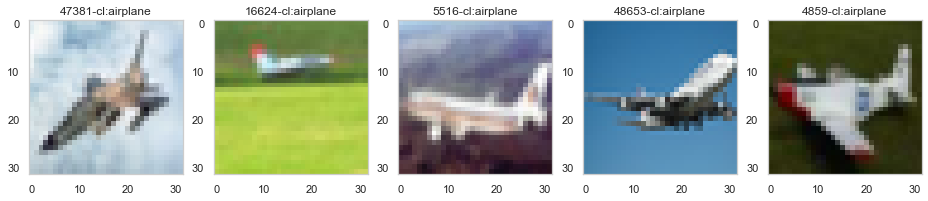

automobile


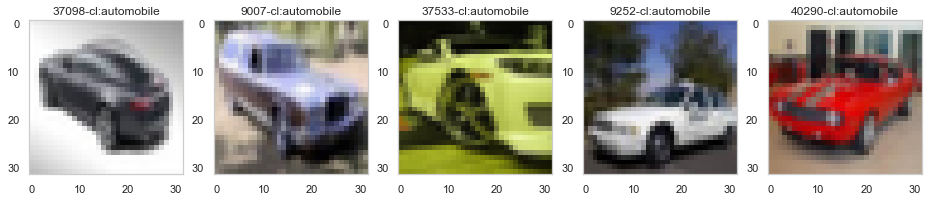

bird


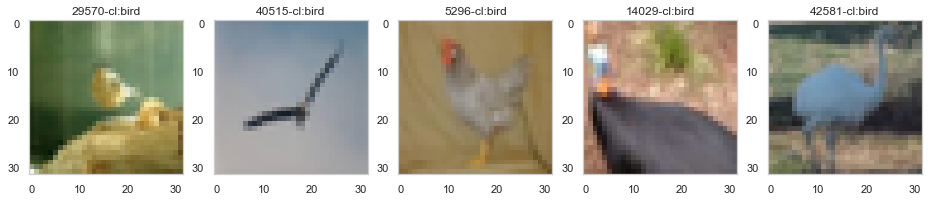

cat


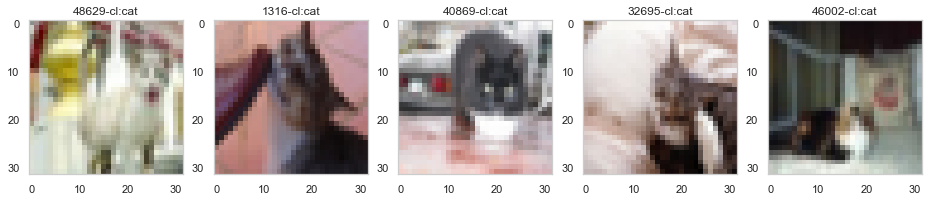

deer


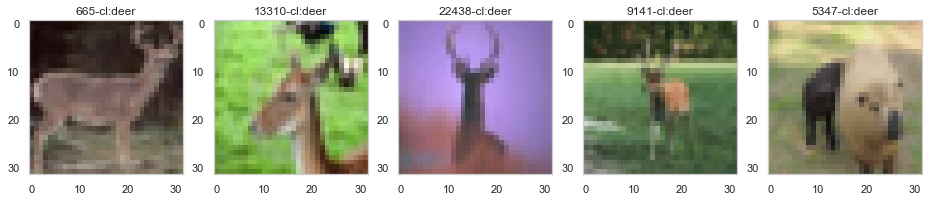

dog


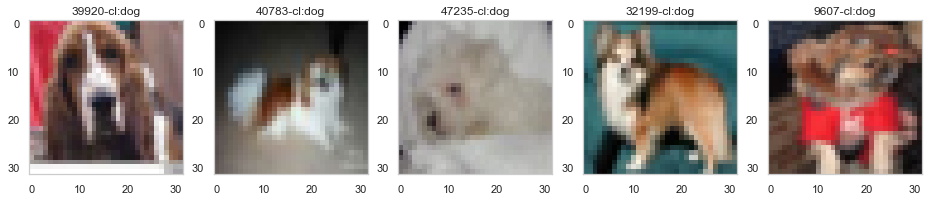

frog


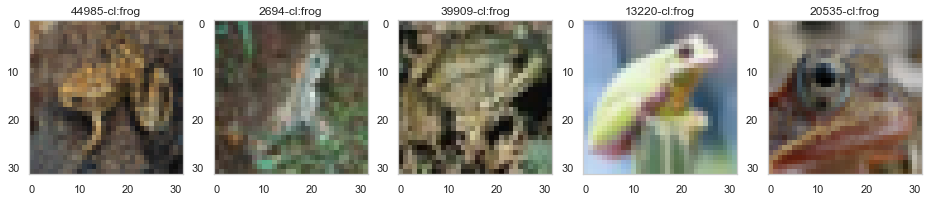

horse


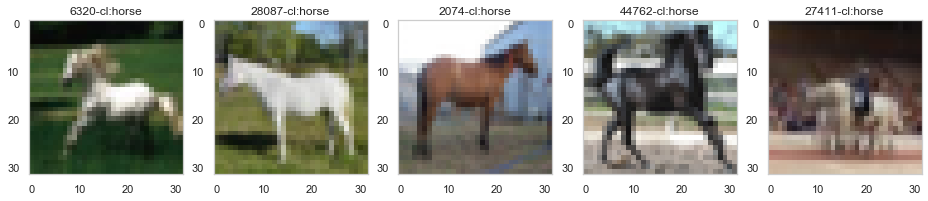

ship


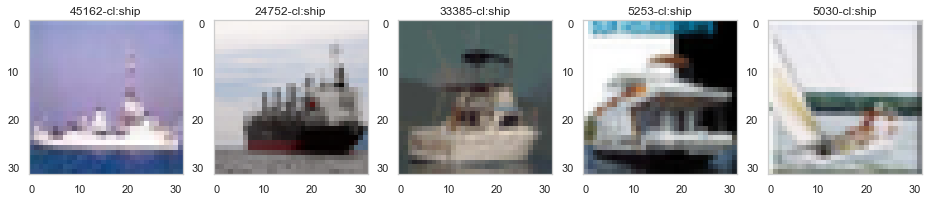

truck


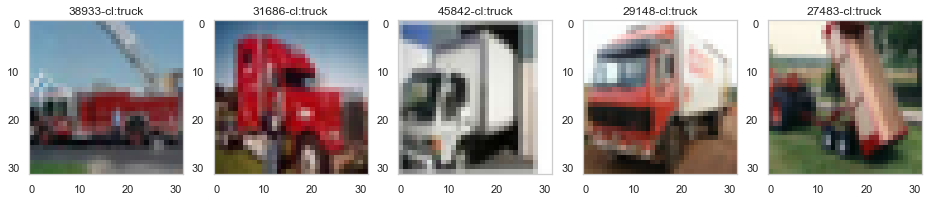

In [47]:
visualize_n_represenative_class_examples(5,x_train,y_train)

#### Examples of mistakes within classes

airplane


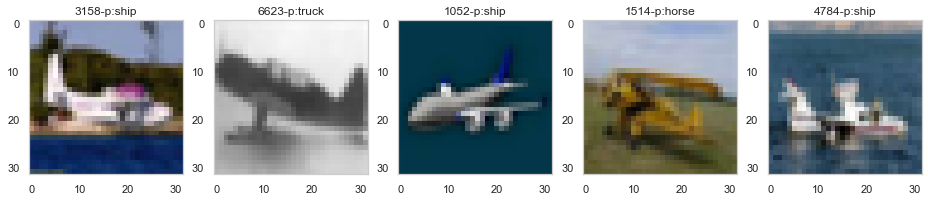

automobile


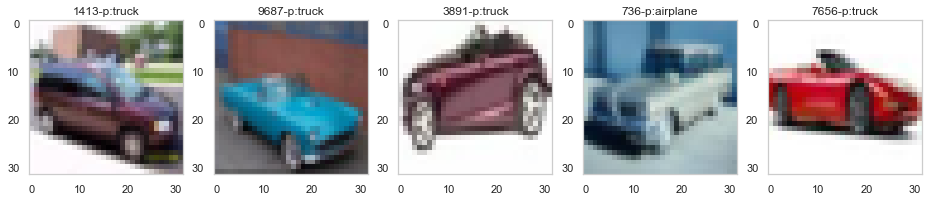

bird


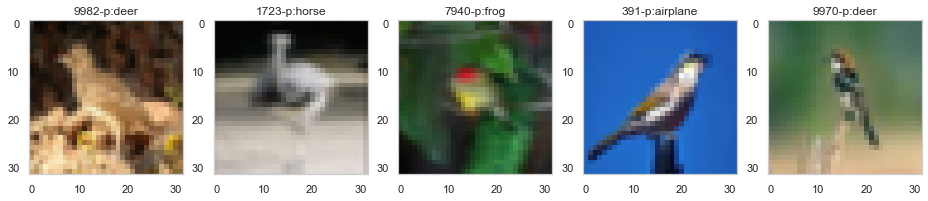

cat


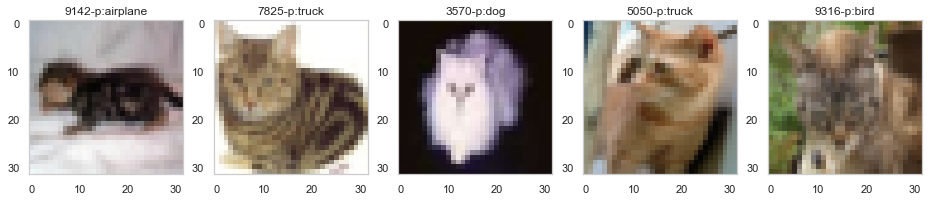

deer


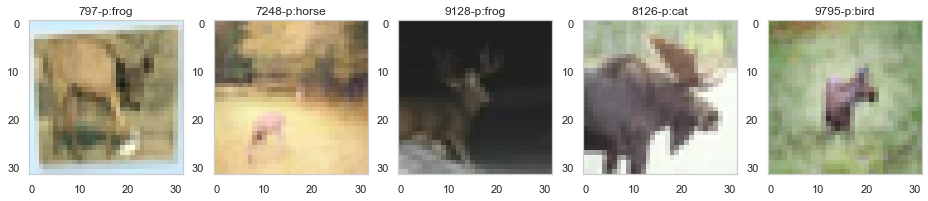

dog


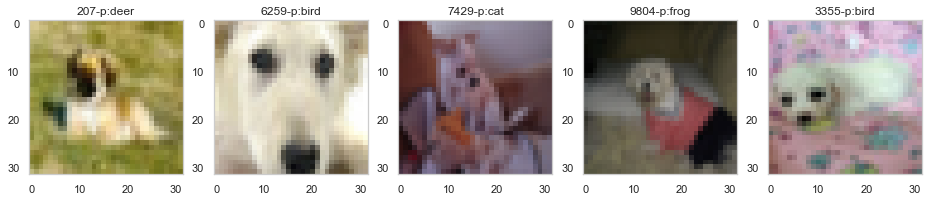

frog


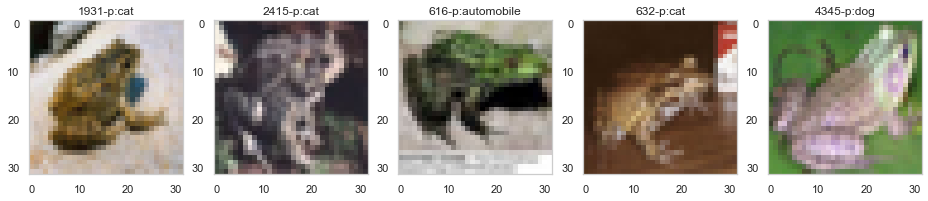

horse


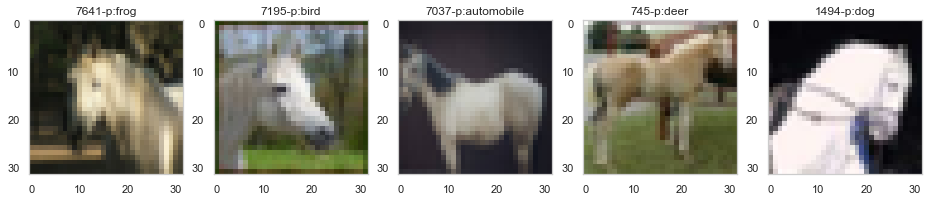

ship


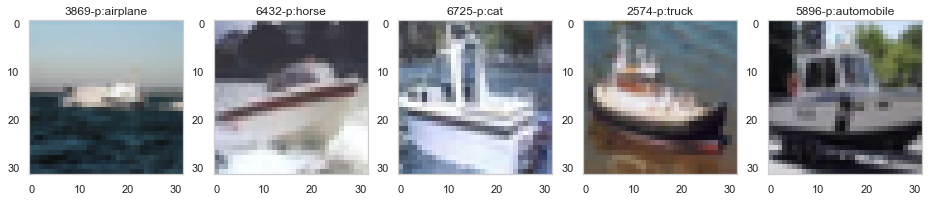

truck


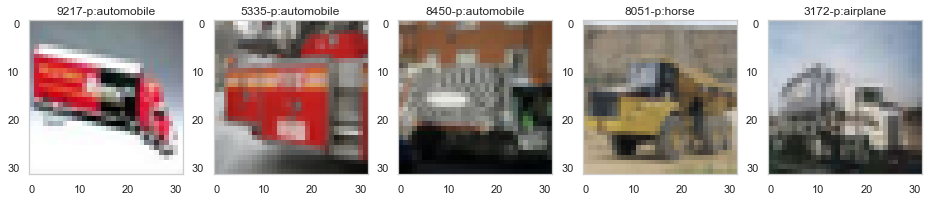

In [65]:
# visualize_n_differing_for_each_class(5,x_test,y_test,predicted_labels)